In [113]:
GPS_PATH = "task2-gps.csv"
LOCATIONS_PATH = "task2-list.csv"

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from datetime import datetime

In [115]:
pd.options.display.max_rows = 100

In [116]:
gps = pd.read_csv(GPS_PATH)
gps.head()

,Id,Timestamp,Lng,Lat,Stat1,Stat2,Stat3,Stat4
0,1064,2021-06-08 00:00:49+02,17.203600,52.401814,0,0.0,5.0,9.5
1,1064,2021-06-08 00:01:51+02,17.203615,52.401802,0,0.0,5.0,9.7
2,1064,2021-06-08 00:02:51+02,17.203640,52.401821,0,0.0,5.0,9.8
3,1064,2021-06-08 00:03:51+02,17.203663,52.401806,0,0.0,5.0,10.0
4,1064,2021-06-08 00:04:51+02,17.203669,52.401787,0,0.0,5.0,9.9


In [117]:
locations = pd.read_csv(LOCATIONS_PATH)
locations.head()

,Id,Lat,Lng
0,1,52.01112,18.51057
1,2,52.34539,17.06426
2,3,52.40121,17.20518
3,4,51.70963,17.72540


In [118]:
def compute_distances(gps_data, locations):
    distances = []
    p1 = np.array((gps_data["Lat"], gps_data["Lng"]))
    for _, loc in locations.iterrows():
        p2 = np.array((loc["Lat"], loc["Lng"]))
        
        distances.append(np.linalg.norm(p1 - p2))
    
    return distances

In [119]:
# computing distances to each location
distances = gps.apply(
    func=compute_distances,
    locations=(locations),
    axis=1,
    result_type="expand"
)

# renaming columns in distances dataframe to ids of locations 
distances.columns = locations["Id"]

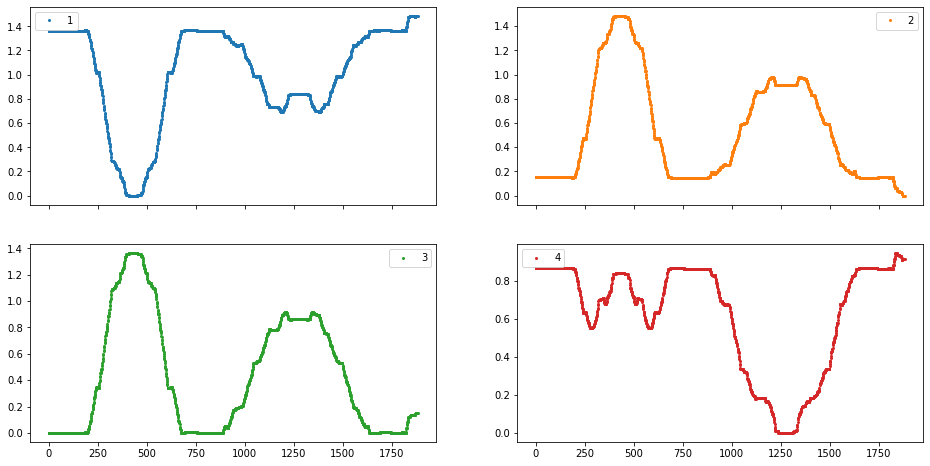

In [120]:
distances.plot(
    lw=0,
    marker='.',
    subplots=True,
    layout=(-1,2),
    figsize=(16, 8),
    markersize=4
);

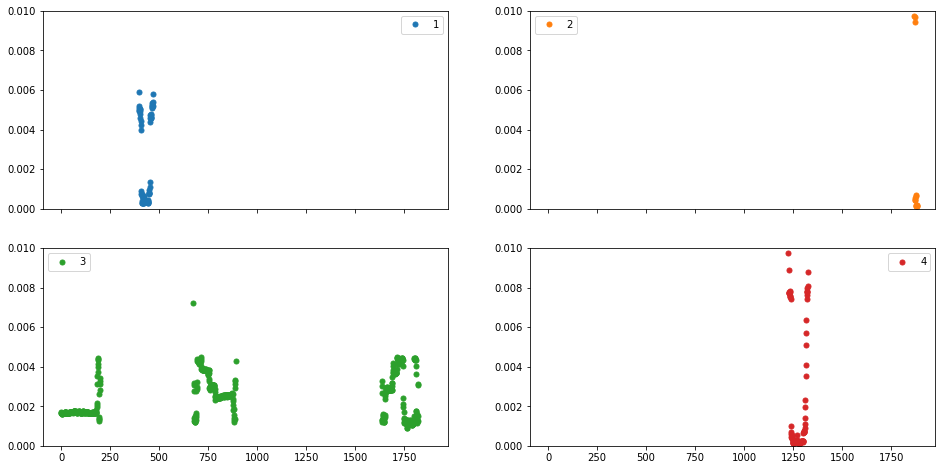

In [121]:
axs = distances.plot(
    lw=0,
    marker='.',
    subplots=True,
    layout=(-1,2),
    figsize=(16, 8),
    markersize=10
);

for ax in axs.flatten():
    ax.set_ylim([0, 0.01])

In [122]:
THRESHOLD = 0.005

In [123]:
def get_time(timestamp, dt_format="%Y-%m-%d %H:%M:%S+02"):
    return datetime.strptime(timestamp, dt_format).time().strftime("%H:%M:%S")

arrive_departure_ids = []
arrive_departure_time = {}

for col in distances.columns:
    in_place = False
    arrive_departure_time[col] = []
    for i, dist in enumerate(distances[col]):
        if not in_place and dist <= THRESHOLD:
            in_place = True 

            time = get_time(gps.loc[i, "Timestamp"])            
            arrive_departure_time[col].append([time, "-"])   
            
            arrive_departure_ids.append(i)
        if in_place and dist > THRESHOLD:
            in_place = False

            time = get_time(gps.loc[i, "Timestamp"])
            arrive_departure_time[col][-1][1] = time

            arrive_departure_ids.append(i)

arrive_departure_ids.append(distances.shape[0])

arrive_departure_ids.sort()

In [124]:
lng_c, lat_c = locations["Lng"].mean(), locations["Lat"].mean()

m = folium.Map(location=[lat_c, lng_c], zoom_start=9)

for _, loc in locations.iterrows():

    adt = arrive_departure_time[loc["Id"]]
    
    adt_str = f"<b>Location id: {int(loc['Id'])}</b><br><br>"
    for i, ad in enumerate(adt):
        adt_str += (f"{i+1}. Arrive: {ad[0]} Departure: {ad[1]} <br>")

    iframe = folium.IFrame(adt_str)
    popup = folium.Popup(iframe, min_width=300, max_width = 300)
    folium.Marker(
        location=[loc["Lat"], loc["Lng"]],
        popup=popup
    ).add_to(m)


def add_polyline(m, start_id, stop_id, color):
    folium.PolyLine(
        gps.loc[start_id : stop_id, ["Lat", "Lng"]].values.tolist(),
        color=color,
        weight=10,
        opacity=0.5
    ).add_to(m)


previous_id = 0
in_place = False
for i, id in enumerate(arrive_departure_ids):
    if id == 0:
        in_place = True

    if i == 0:
        previous_id = id
        continue

    if in_place:
        in_place = False
        add_polyline(m, previous_id, id, "green")
    else:
        in_place = True
        add_polyline(m, previous_id, id, "red")

    previous_id = id

m